In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

### Scenario

You are working as an analyst with this internet service provider. You are provided with this historical data about your company's customers and their **churn trends**. Your task is to build a machine learning model that will help the company **identify customers that are more likely to default/churn** and thus prevent losses from such customers.

In [2]:
df = pd.read_csv('Customer-Churn.csv')

In [3]:
print(df.shape)
df.head(3)

(7043, 16)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   object 
 15  Churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

### Basic Data Cleaning

In [5]:
df.head(1)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No


In [6]:
# check unique values for the features
[print(col, df[col].unique())for col in  df.select_dtypes('object')];

gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
TotalCharges ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn ['No' 'Yes']


In [7]:
# clean up some features

# convert Churn to 1 (Yes) and 0 (No)
df.loc[df['Churn'] == "Yes", 'Churn'] = 1.0
df.loc[df['Churn'] == "No", 'Churn'] = 0.0
df['Churn'] = pd.to_numeric(df['Churn'])

# convert total charges to float value
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [8]:
df['Churn'].dtype, df['TotalCharges'].dtype

(dtype('float64'), dtype('float64'))

### Check Null Values and handle them

In [9]:
# check for null values
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
df.query('TotalCharges.isna()')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,Yes,No,Yes,Yes,Yes,No,Two year,52.55,NaN,0.0
753,Male,0,No,Yes,0,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,20.25,NaN,0.0
936,Female,0,Yes,Yes,0,Yes,Yes,Yes,Yes,No,Yes,Yes,Two year,80.85,NaN,0.0
1082,Male,0,Yes,Yes,0,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,25.75,NaN,0.0
1340,Female,0,Yes,Yes,0,No,Yes,Yes,Yes,Yes,Yes,No,Two year,56.05,NaN,0.0
3331,Male,0,Yes,Yes,0,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,19.85,NaN,0.0
3826,Male,0,Yes,Yes,0,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,25.35,NaN,0.0
4380,Female,0,Yes,Yes,0,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,20.00,NaN,0.0
5218,Male,0,Yes,Yes,0,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,19.70,NaN,0.0
6670,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,Yes,Yes,No,Two year,73.35,NaN,0.0


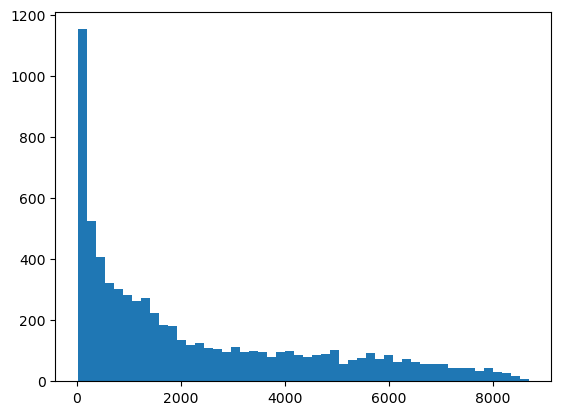

In [11]:
# quick check on the distribution of total charges
plt.hist(df['TotalCharges'], bins=50);

In [12]:
# based on the data overview above - set the nan total charges to 0
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = 0

### Prepare Data for Model

In [13]:
X = df.loc[:, ['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']]
y = df['Churn']

In [14]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [15]:
# check for class imbalance on TARGET
y.value_counts() / y.shape[0]

0.0    0.73463
1.0    0.26537
Name: Churn, dtype: float64

**-> We can see a class imbalance on target**

In [16]:
# fn to create pipelines - note that no encoding for categorials is inclused sicne all features are numericals
def custom_pipeline(scaler, model, sampler=None):
    if sampler:
        return Pipeline([
            ('scaler', scaler),
            ('sampler', sampler),
            ('model', model)
        ])
    else:
        return Pipeline([
            ('scaler', scaler),
            ('model', model)
        ])

In [17]:
def show_confusion_matrix(y_pred, y_test, classes, title):
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(colorbar=False)
    disp.ax_.set_title(title)
    plt.show()

### Model 1: No sampler to address class imbalance on target

In [18]:
clf_base = custom_pipeline(StandardScaler(), LogisticRegression())
clf_base.fit(X_train, y_train);

In [19]:
y_pred_base = clf_base.predict(X_test)

In [20]:
print('LogisticRegression - no sampler')
print(classification_report(y_test, y_pred_base))

LogisticRegression - no sampler
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.87      1552
         1.0       0.66      0.45      0.54       561

    accuracy                           0.79      2113
   macro avg       0.74      0.68      0.70      2113
weighted avg       0.78      0.79      0.78      2113



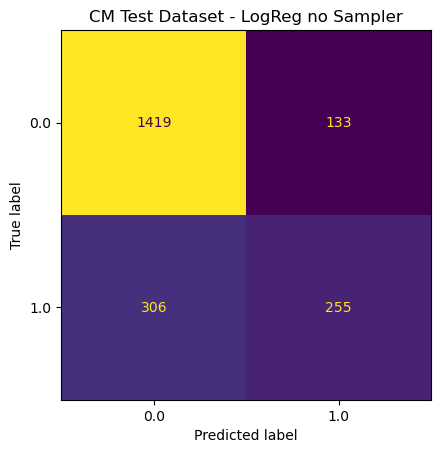

In [21]:
show_confusion_matrix(y_pred_base, y_test, clf_base[1].classes_, 'CM Test Dataset - LogReg no Sampler')

### Model 2 and 3: Use Upsampler to address class imbalance on target - SMOTE and RandomOverSampler

In [22]:
clf_SMOTE = custom_pipeline(StandardScaler(), LogisticRegression(), SMOTE())
clf_SMOTE.fit(X_train, y_train);

LogisticRegression - SMOTE
              precision    recall  f1-score   support

         0.0       0.89      0.72      0.80      1552
         1.0       0.49      0.75      0.59       561

    accuracy                           0.73      2113
   macro avg       0.69      0.73      0.69      2113
weighted avg       0.78      0.73      0.74      2113



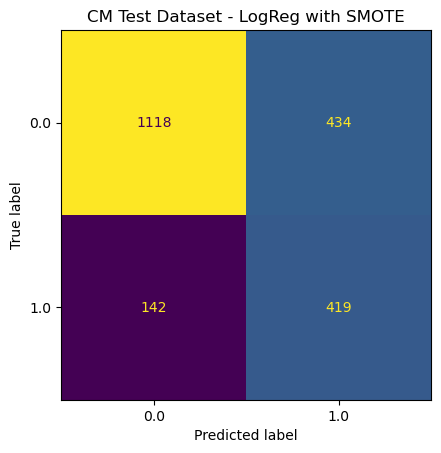

In [23]:
y_pred_smote = clf_SMOTE.predict(X_test)
print('LogisticRegression - SMOTE')
print(classification_report(y_test, y_pred_smote))
show_confusion_matrix(y_pred_smote, y_test, clf_SMOTE[2].classes_, 'CM Test Dataset - LogReg with SMOTE')

In [24]:
clf_ros = custom_pipeline(StandardScaler(), LogisticRegression(), RandomOverSampler())
clf_ros.fit(X_train, y_train);

LogisticRegression - ROS
              precision    recall  f1-score   support

         0.0       0.89      0.72      0.79      1552
         1.0       0.49      0.75      0.59       561

    accuracy                           0.73      2113
   macro avg       0.69      0.73      0.69      2113
weighted avg       0.78      0.73      0.74      2113



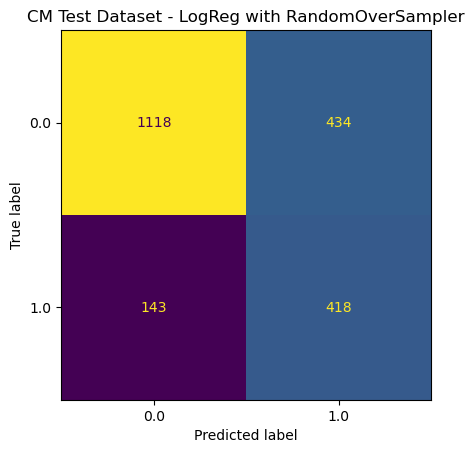

In [25]:
y_pred_ros = clf_ros.predict(X_test)
print('LogisticRegression - ROS')
print(classification_report(y_test, y_pred_ros))
show_confusion_matrix(y_pred_ros, y_test, clf_ros[2].classes_, 'CM Test Dataset - LogReg with RandomOverSampler')

### Model 4: Use Downsampler to address class imbalance on target 

In [26]:
clf_rus = custom_pipeline(StandardScaler(), LogisticRegression(), RandomUnderSampler())
clf_rus.fit(X_train, y_train);

LogisticRegression - RUS
              precision    recall  f1-score   support

         0.0       0.89      0.72      0.80      1552
         1.0       0.49      0.75      0.60       561

    accuracy                           0.73      2113
   macro avg       0.69      0.74      0.70      2113
weighted avg       0.78      0.73      0.74      2113



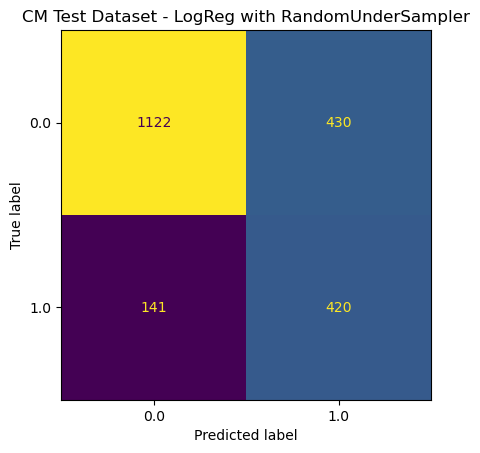

In [27]:
y_pred_rus = clf_rus.predict(X_test)
print('LogisticRegression - RUS')
print(classification_report(y_test, y_pred_rus))
show_confusion_matrix(y_pred_rus, y_test, clf_rus[2].classes_, 'CM Test Dataset - LogReg with RandomUnderSampler')

### Compare outcomes

In [28]:
def add_scores_to_overall_results(df_results, scores_test, sampler, estimator):
    df_results.loc[df_results.shape[0]] = [get_class_name(estimator), get_class_name(sampler) if sampler else None,
                                          scores_test.at["accuracy","f1-score"], scores_test.at["1.0","f1-score"],
                                          scores_test.at["1.0","precision"], scores_test.at["1.0","recall"],
                                          scores_test.at["0.0","f1-score"], scores_test.at["0.0","precision"],
                                          scores_test.at["0.0","recall"]]
    
def get_class_name(cl):
    return cl.__class__.__name__

In [29]:
model_comparisson = pd.DataFrame([], columns=['model', 'sampler', 'f1_score', 'yes_f1', \
                                          'yes_precision', 'yes_recall', 'no_f1', 'no_precision', 'no_recall'])

In [30]:
# Add the outcomes from all models to an overview table
add_scores_to_overall_results(model_comparisson, 
                              pd.DataFrame(classification_report(y_test, y_pred_base, output_dict=True)).T, 
                              None, 
                              clf_base[1])

add_scores_to_overall_results(model_comparisson, 
                              pd.DataFrame(classification_report(y_test, y_pred_smote, output_dict=True)).T, 
                              clf_SMOTE[1], 
                              clf_SMOTE[2])

add_scores_to_overall_results(model_comparisson, 
                              pd.DataFrame(classification_report(y_test, y_pred_ros, output_dict=True)).T, 
                              clf_ros[1], 
                              clf_ros[2])

add_scores_to_overall_results(model_comparisson, 
                              pd.DataFrame(classification_report(y_test, y_pred_rus, output_dict=True)).T, 
                              clf_rus[1], 
                              clf_rus[2])

In [31]:
# sort by f1 score
model_comparisson.sort_values(by='f1_score', ascending=False)

,model,sampler,f1_score,yes_f1,yes_precision,yes_recall,no_f1,no_precision,no_recall
0,LogisticRegression,None,0.792239,0.537408,0.657216,0.454545,0.866036,0.822609,0.914304
3,LogisticRegression,RandomUnderSampler,0.729768,0.595322,0.494118,0.748663,0.797158,0.888361,0.722938
1,LogisticRegression,SMOTE,0.727402,0.592645,0.491208,0.746881,0.795164,0.887302,0.720361
2,LogisticRegression,RandomOverSampler,0.726929,0.591649,0.490610,0.745098,0.794881,0.886598,0.720361


- as can be seen in the overview, the f1 score is the highest for the Logistic Regression without any measures against class imabalance; however here we also see the lowest recall for the postive class (which was under represented in the target)